In [1]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [2]:
# from src.KalmanFilterSV import *
from src.KalmanFilterCorr import *
from src.Heston import *
from filtering.filtering import particle_filter as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 2.0,
    'theta': 0.04,
    'xi': 0.2
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
assert 2 * params['kappa'] * params['theta'] > params['xi']**2, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=10, trading_days=252, intraday_intervals=39, seed=1
)
R_daily = daily_returns.copy()

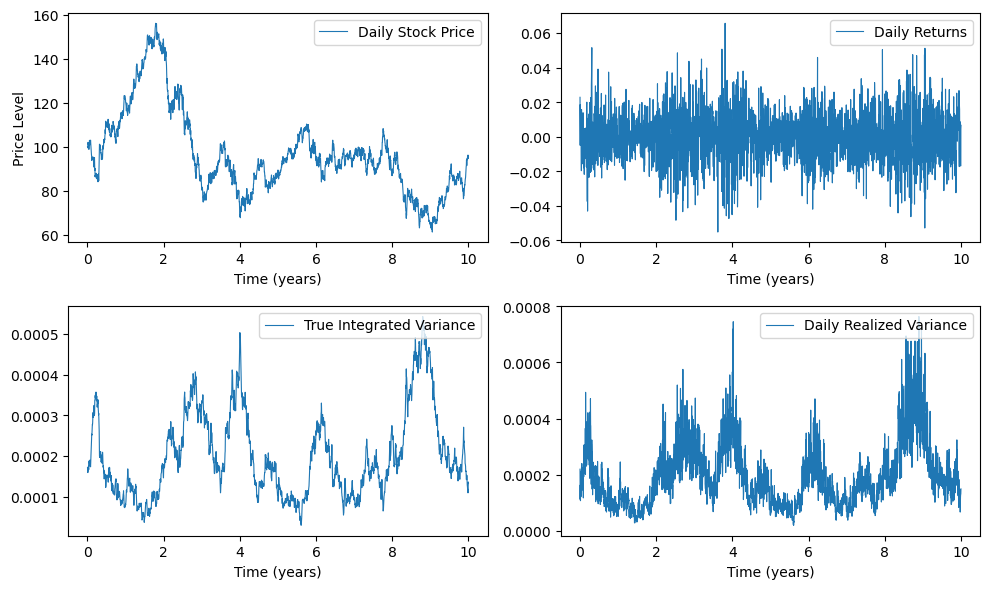

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0             # v0
]

In [6]:
burnin = 500
dt = 1  # Daily

# ============================================================================
# 1. BOTH Measurements: Uses both returns and RV
# ============================================================================

# Instantiate the Kalman filter for BOTH measurement type.
hkf_both = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=R_daily, rv=daily_RV)
# For BOTH, parameter order is: [kappa, theta, xi, mu, sigma, rho]
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001, -0.001])
param_bound_both = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (-0.2, 0.2),      # mu
    (0.01, 2.0)       # sigma
]
# Fit the model using the burnin (likelihood uses only t ≥ burnin).
fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)
# Retrieve filtered variance.
V_filt_both = hkf_both.get_filtered_variance()

# ============================================================================
# 2. RETURNS Measurement: Uses only returns data
# ============================================================================

hkf_returns = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=R_daily)
# Parameter order for RETURNS is: [kappa, theta, xi, mu, rho]
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001, -0.001])
param_bound_returns = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (-0.2, 0.2)       # mu
]
fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)
V_filt_returns = hkf_returns.get_filtered_variance()

# ============================================================================
# 3. RV Measurement: Uses only realized variance data
# ============================================================================

hkf_rv = HestonKalmanFilterCorr(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
# For RV-only, only the RV data is provided.
hkf_rv.set_data(rv=daily_RV)
# Parameter order for RV is: [kappa, theta, xi, sigma]
# initial_params_rv = np.array([0.8, 0.01, 0.001, 0.5])
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])
param_bound_both = [
    (1, 3), # kappa
    (1e-6, None),     # theta
    (1e-6, None),     # xi
    (1e-6, 2.0)       # sigma
]
fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)
V_filt_rv = hkf_rv.get_filtered_variance()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19622D+04    |proj g|=  9.89000D-01

At iterate    1    f= -2.19701D+04    |proj g|=  9.83144D-01

At iterate    2    f= -2.19854D+04    |proj g|=  9.83194D-01

At iterate    3    f= -2.20055D+04    |proj g|=  1.41243D+03

At iterate    4    f= -2.20095D+04    |proj g|=  2.23038D+04

At iterate    5    f= -2.20104D+04    |proj g|=  1.66957D+03

At iterate    6    f= -2.20106D+04    |proj g|=  1.63905D+03

At iterate    7    f= -2.20107D+04    |proj g|=  1.57097D+03

At iterate    8    f= -2.20107D+04    |proj g|=  2.36265D+03

At iterate    9    f= -2.20108D+04    |proj g|=  3.35165D+03

At iterate   10    f= -2.20108D+04    |proj g|=  1.19503D+03

At iterate   11    f= -2.20108D+04    |proj g|=  3.87043D+02

At iterate   12    f= -2.20109D+04    |proj g|=  3.52784D+02

At iterate   13    f= -2.2

/Users/hyunminhong/anaconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0



QMLE Results for Heston Model:
At iterate   35    f= -2.20308D+04    |proj g|=  1.99984D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     45     42     0     0   2.000D+00  -2.203D+04
  F =  -22030.796118442493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

--------------------------------------------------
kappa: 0.003558
theta: 0.000347
xi: 0.000610
mu: -0.000105
sigma: 0.000156
rho: -0.255033
Negative Log-Likelihood: -22030.796118
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 3.55809996e-03  3.46732555e-04  6.09912861e-04 -1

In [7]:
pf_heston = pf.PFHeston(np.log(S_daily), N=5000, is_log=True)

param_bounds = [
    (0.05, 0.5),   # mu
    (1, 3),        # kappa
    (0.05, 0.2),   # theta
    (0.01, 0.8),  # xi
    (-1, 0),       # rho
    V0             # v0
]

V_pf, param_steps = pf_heston.filter(param_bounds, predict_obs=False)
V_pf = V_pf / 252

resampling since: 945.8196869351472
resampling since: 1805.1642242620508
resampling since: 218.19881542325427
resampling since: 811.9560816673734
resampling since: 2245.4741397886296
resampling since: 3155.002650535046
resampling since: 3440.4704069468703
resampling since: 2270.691931345469
resampling since: 1186.0080132740159
resampling since: 2220.349077501935
resampling since: 3003.7576307534823
resampling since: 1223.920116607087
resampling since: 2882.3524507034545
resampling since: 2311.7180605271546
resampling since: 2989.606815760957
resampling since: 3253.868772358532
resampling since: 1515.5980787549054
resampling since: 2586.9615362556865
resampling since: 2292.747413959427
resampling since: 3236.233949294961
resampling since: 1744.2711432503982
resampling since: 3121.3961472646815
resampling since: 2671.9646349628506
resampling since: 3461.830961662391
resampling since: 1039.0065678443777
resampling since: 1890.4868715491514
resampling since: 1526.4858504089814
resampling s

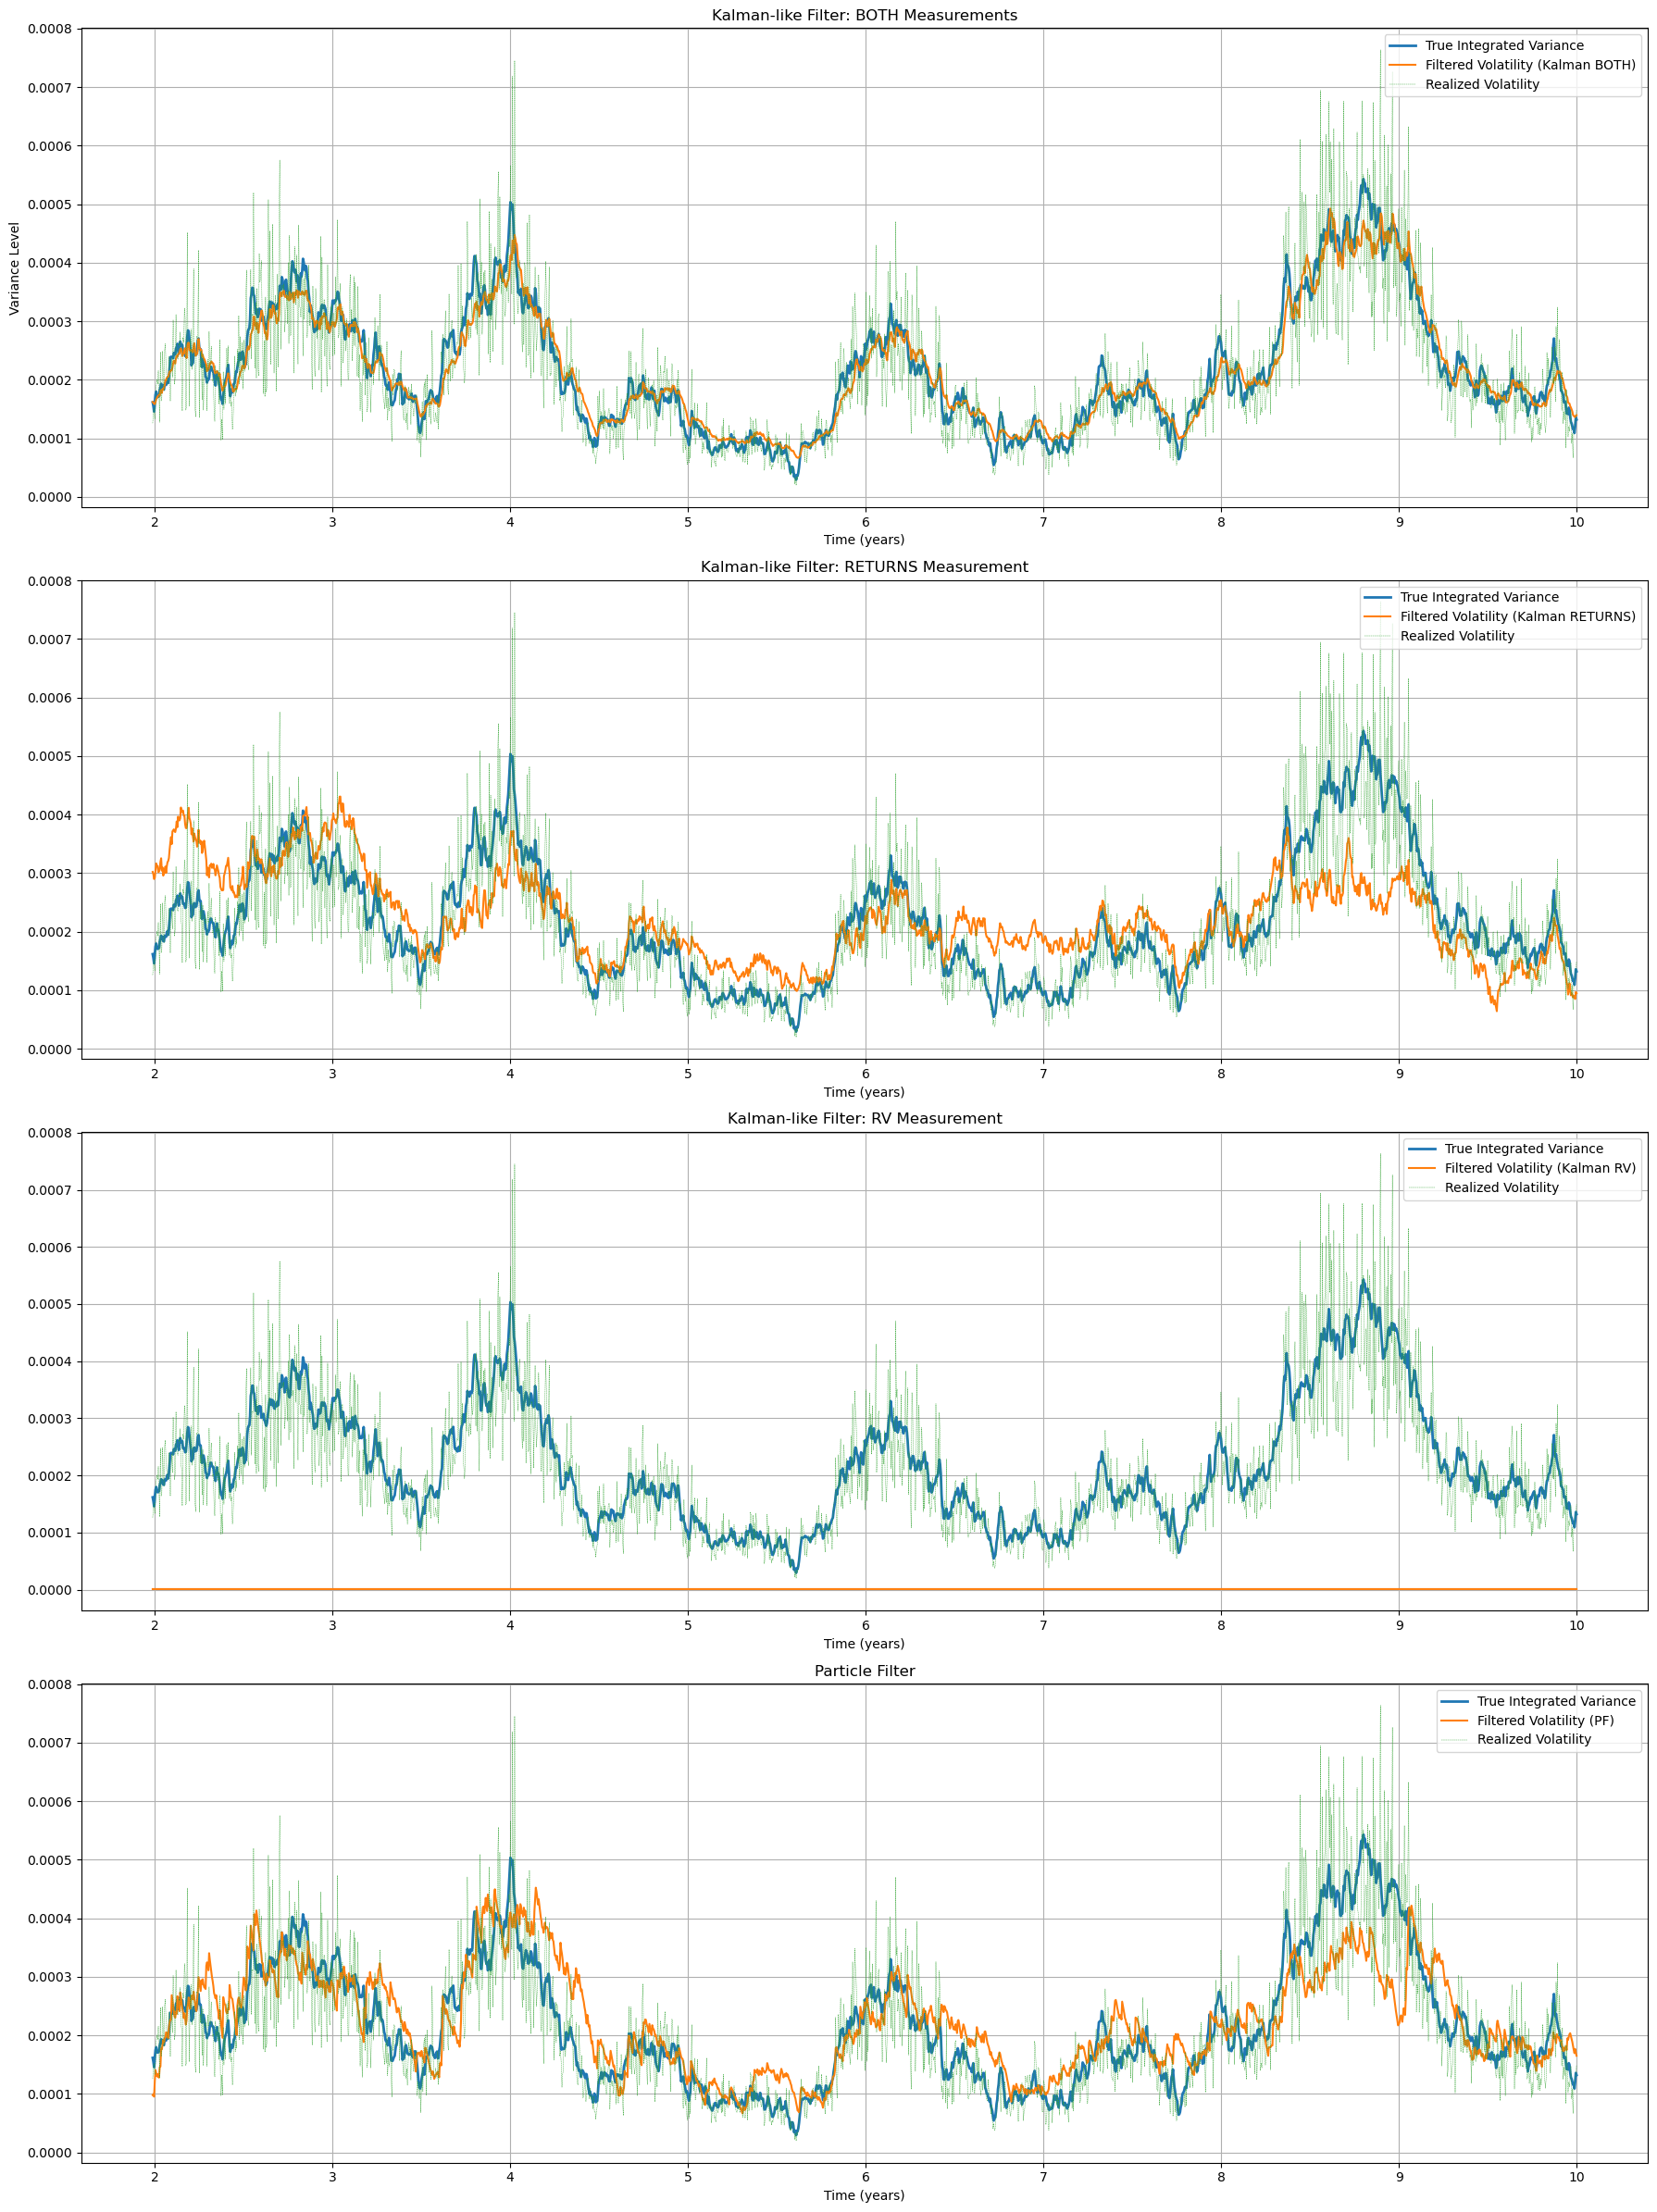

RMSE (PF - Filtered vs True): 0.000061
RMSE (RETURNS - Filtered vs True): 0.000074
RMSE (BOTH - Filtered vs True): 0.000025
RMSE (RV - Filtered vs True): 0.000241

--- Model Summary: BOTH ---

Heston Kalman Filter Summary
Measurement Type: both
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.003558
theta: 0.000347
xi: 0.000610
mu: -0.000105
sigma: 0.000156
rho: -0.255033

Negative Log-Likelihood: -22030.796118
Convergence: True

AIC: -44049.592237
BIC: -44014.602533

--- Model Summary: RETURNS ---

Heston Kalman Filter Summary
Measurement Type: returns
Time Interval (dt): 1
Initial Variance (V0): 0.010000
Initial Covariance (P0): 0.100000

Fitted Parameters:
--------------------------------------------------
kappa: 0.007805
theta: 0.000221
xi: 0.000660
mu: -0.000239
rho: -0.990000

Negative Log-Likelihood: -5683.548236
Convergence: True

AIC: -11357.096472
BIC: -11327

In [8]:
burnin = 500

# Create 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(18, 24))

# 1: BOTH measurements
axes[0].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[0].plot(time_daily[burnin:], V_filt_both[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)
# axes[0].plot(time_daily[burnin:], hkf_both.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman BOTH)", lw=1.5)

axes[0].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[0].set_title("Kalman-like Filter: BOTH Measurements")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Variance Level")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# 2: RETURNS measurement
axes[1].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[1].plot(time_daily[burnin:], V_filt_returns[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)
# axes[1].plot(time_daily[burnin:], hkf_returns.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RETURNS)", lw=1.5)

axes[1].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[1].set_title("Kalman-like Filter: RETURNS Measurement")
axes[1].set_xlabel("Time (years)")
axes[1].legend(loc="upper right")
axes[1].grid(True)

# 3: RV measurement
axes[2].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[2].plot(time_daily[burnin:], V_filt_rv[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)
# axes[2].plot(time_daily[burnin:], hkf_rv.get_predicted_variance()[burnin:], label="Filtered Volatility (Kalman RV)", lw=1.5)

axes[2].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[2].set_title("Kalman-like Filter: RV Measurement")
axes[2].set_xlabel("Time (years)")
axes[2].legend(loc="upper right")
axes[2].grid(True)

# 4: Particle Filter
axes[3].plot(time_daily[burnin:], daily_true_V[burnin:], label="True Integrated Variance", lw=2)
axes[3].plot(time_daily[burnin:], V_pf[burnin:], label="Filtered Volatility (PF)", lw=1.5)
axes[3].plot(time_daily[burnin:], daily_RV[burnin:], label="Realized Volatility", lw=0.3, linestyle="--")
axes[3].set_title("Particle Filter")
axes[3].set_xlabel("Time (years)")
axes[3].legend(loc="upper right")
axes[3].grid(True)

plt.tight_layout()
plt.show()

# Compute RMSE (Post Burnin)
true_post = daily_true_V[burnin:]
rmse_both = np.sqrt(np.mean((true_post - V_filt_both[burnin:]) ** 2))
rmse_returns = np.sqrt(np.mean((true_post - V_filt_returns[burnin:]) ** 2))
rmse_rv = np.sqrt(np.mean((true_post - V_filt_rv[burnin:]) ** 2))
rmse_pf = np.sqrt(np.mean((true_post - V_pf[burnin:]) ** 2))

print(f"RMSE (PF - Filtered vs True): {rmse_pf:.6f}")
print(f"RMSE (RETURNS - Filtered vs True): {rmse_returns:.6f}")
print(f"RMSE (BOTH - Filtered vs True): {rmse_both:.6f}")
print(f"RMSE (RV - Filtered vs True): {rmse_rv:.6f}")

# Print Model Summaries for Each Measurement Type
print("\n--- Model Summary: BOTH ---")
hkf_both.summary()

print("\n--- Model Summary: RETURNS ---")
hkf_returns.summary()

print("\n--- Model Summary: RV ---")
hkf_rv.summary()


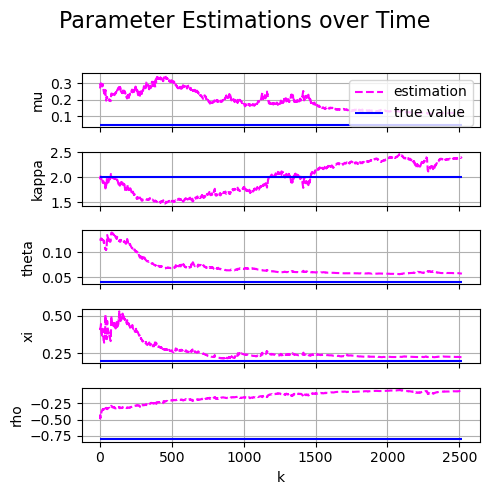

In [9]:
param_names = ['mu', 'kappa', 'theta', 'xi', 'rho']

fig, axs = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
fig.suptitle('Parameter Estimations over Time', fontsize=16)

# Plot each parameter
for i in range(5):
    axs[i].plot(param_steps[i], linestyle='--', color='magenta', label='estimation')
    axs[i].hlines(params[param_names[i]], 0, param_steps.shape[1]-1, colors='blue', label='true value')
    axs[i].set_ylabel(param_names[i])
    axs[i].grid(True)

# Set common x-axis label
axs[-1].set_xlabel('k')

# Only add one legend (avoid repeated)
axs[0].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

In [13]:
np.zeros((1,2))

array([[0., 0.]])